# Install packages and download data

In [ ]:
! pip install expression-copilot[torch]
! pip install patchworklib

We download the CITE-seq dataset from NeurIPS 2021 Open Problems dataset (GSE194122).

In [ ]:
! wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE194nnn/GSE194122/suppl/GSE194122%5Fopenproblems%5Fneurips2021%5Fcite%5FBMMC%5Fprocessed.h5ad.gz
! gunzip GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad.gz

# Calculate EPS on multi-omics data (CITE-seq)

> (Estimated time: ~15 min)

In this vignette, we show how to calculate EPS and SPS on single cell multi-omics data. And found their relationship with gene expression predictability.


In [8]:
import scanpy as sc
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import patchworklib as pw

from expression_copilot import ExpressionCopilotModel

<Figure size 100x100 with 0 Axes>

In [3]:
adata = sc.read_h5ad('GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad')


/usr/local/lib/python3.12/dist-packages/anndata/_core/anndata.py:1793: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


We split the gene expression and surface protion

In [4]:
gex = adata[:, adata.var['feature_types'] == 'GEX'].copy()
other = adata[:, adata.var['feature_types'] != 'GEX'].copy()

gex.X = gex.layers['counts'].copy()
sc.pp.highly_variable_genes(
    gex, layer="counts", n_top_genes=2000, flavor="seurat_v3", batch_key='batch', subset=True
)
del adata

Then we calculate EPS and run baseline model on every batch

In [5]:
def run_batch(gex, other, batch):
    print(f'Preprocessing {batch}...')
    other.var["highly_variable"] = True
    sc.pp.scale(other, max_value=10)
    sc.pp.pca(other, n_comps=20)

    gex.obsm['X_adt_emb'] = other.obsm['X_pca']

    gex.X = gex.layers['counts']
    model = ExpressionCopilotModel(gex, image_key='X_adt_emb')

    eps = model.calc_metrics_per_gene()
    gene_metrics, _ = model.calc_baseline_metrics(method='mlp')
    gene_df = eps.merge(gene_metrics, left_index=True, right_index=True)
    return gene_df

In [6]:
# This cell will take about 10 minutes in Colab, so take a coffee!
res_dict = {}
for batch in gex.obs['batch'].unique():
    print(batch)
    gex_batch = gex[gex.obs['batch'] == batch].copy()
    other_batch = other[other.obs['batch'] == batch].copy()
    df = run_batch(gex_batch, other_batch, batch)
    res_dict[batch] = df
    print('='*100)

s1d1
Preprocessing s1d1...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:15:28.742 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
           EPS
HBB   0.060394
RPS2  0.075135
RPL3  0.075183
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval =

s1d2
Preprocessing s1d2...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:16:18.999 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
           EPS
RPS2  0.113717
CD3D  0.116320
MNDA  0.117992
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(y_hat, y, axis=0)
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(a, b)
2025-09-20 12:16:58.925 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene me

s1d3
Preprocessing s1d3...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:17:03.534 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
            EPS
RPL3   0.039754
RPS2   0.044043
RPS4X  0.049657
2025-09-20 12:17:59.329 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.394859
spearman_corr    0.264856
pearson_pval     0.020895
spearman_pval    0.022067
rmse             0.824068
dtype: float64


s2d1
Preprocessing s2d1...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:18:05.719 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
             EPS
CST3    0.138859
S100A8  0.142531
VCAN    0.144436
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(y_hat, y, axis=0)
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(a, b)
2025-09-20 12:18:52.911 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp

s2d4
Preprocessing s2d4...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:18:58.452 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
           EPS
FCN1  0.097889
IGHM  0.105913
VCAN  0.107070
2025-09-20 12:19:23.520 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.408412
spearman_corr    0.332670
pearson_pval     0.017527
spearman_pval    0.018072
rmse             0.852436
dtype: float64


s2d5
Preprocessing s2d5...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:19:32.006 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
           EPS
NKG7  0.123048
CST3  0.143285
MNDA  0.150259
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(y_hat, y, axis=0)
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(a, b)
2025-09-20 12:20:32.771 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene me

s3d1
Preprocessing s3d1...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:20:38.889 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
             EPS
S100A9  0.087656
S100A8  0.094778
LYZ     0.100949
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(y_hat, y, axis=0)
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(a, b)
2025-09-20 12:21:06.134 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp

s3d6
Preprocessing s3d6...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:21:13.674 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
           EPS
FCN1  0.144730
VCAN  0.152369
MNDA  0.166186
2025-09-20 12:21:59.668 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.347154
spearman_corr    0.273527
pearson_pval     0.014101
spearman_pval    0.015656
rmse             0.869053
dtype: float64


s3d7
Preprocessing s3d7...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:22:07.322 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
             EPS
GNLY    0.104690
S100A9  0.130128
S100A8  0.133827
2025-09-20 12:23:03.033 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.345061
spearman_corr    0.247160
pearson_pval     0.017067
spearman_pval    0.019650
rmse             0.851956
dtype: float64


s4d1
Preprocessing s4d1...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:23:08.671 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
                 EPS
FCN1        0.056791
ALAS2       0.059319
AC020656.1  0.063085
2025-09-20 12:23:52.607 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.402022
spearman_corr    0.295474
pearson_pval     0.017479
spearman_pval    0.018594
rmse             0.840955
dtype: float64


s4d8
Preprocessing s4d8...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:23:56.495 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
             EPS
S100A8  0.038544
FCN1    0.043562
LYZ     0.044624
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:104: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, pearson_pval = pearsonr(y_hat, y, axis=0)
/usr/local/lib/python3.12/dist-packages/expression_copilot/baseline.py:129: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  res = spearmanr(a, b)
2025-09-20 12:24:23.738 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp

s4d9
Preprocessing s4d9...


/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)
2025-09-20 12:24:28.070 | INFO     | expression_copilot.model:calc_metrics_per_gene:63 - Gene metrics: 
             EPS
NKG7    0.093751
IGHM    0.110532
SMIM25  0.130904
2025-09-20 12:25:29.557 | INFO     | expression_copilot.model:calc_baseline_metrics:95 - Baseline: mlp gene metrics: 
pearson_corr     0.411971
spearman_corr    0.306400
pearson_pval     0.014376
spearman_pval    0.012912
rmse             0.844423
dtype: float64


## Plot
Firstly, we visualize the relationship between EPS and per-gene prediction performance (Pearson correlation) in every batch

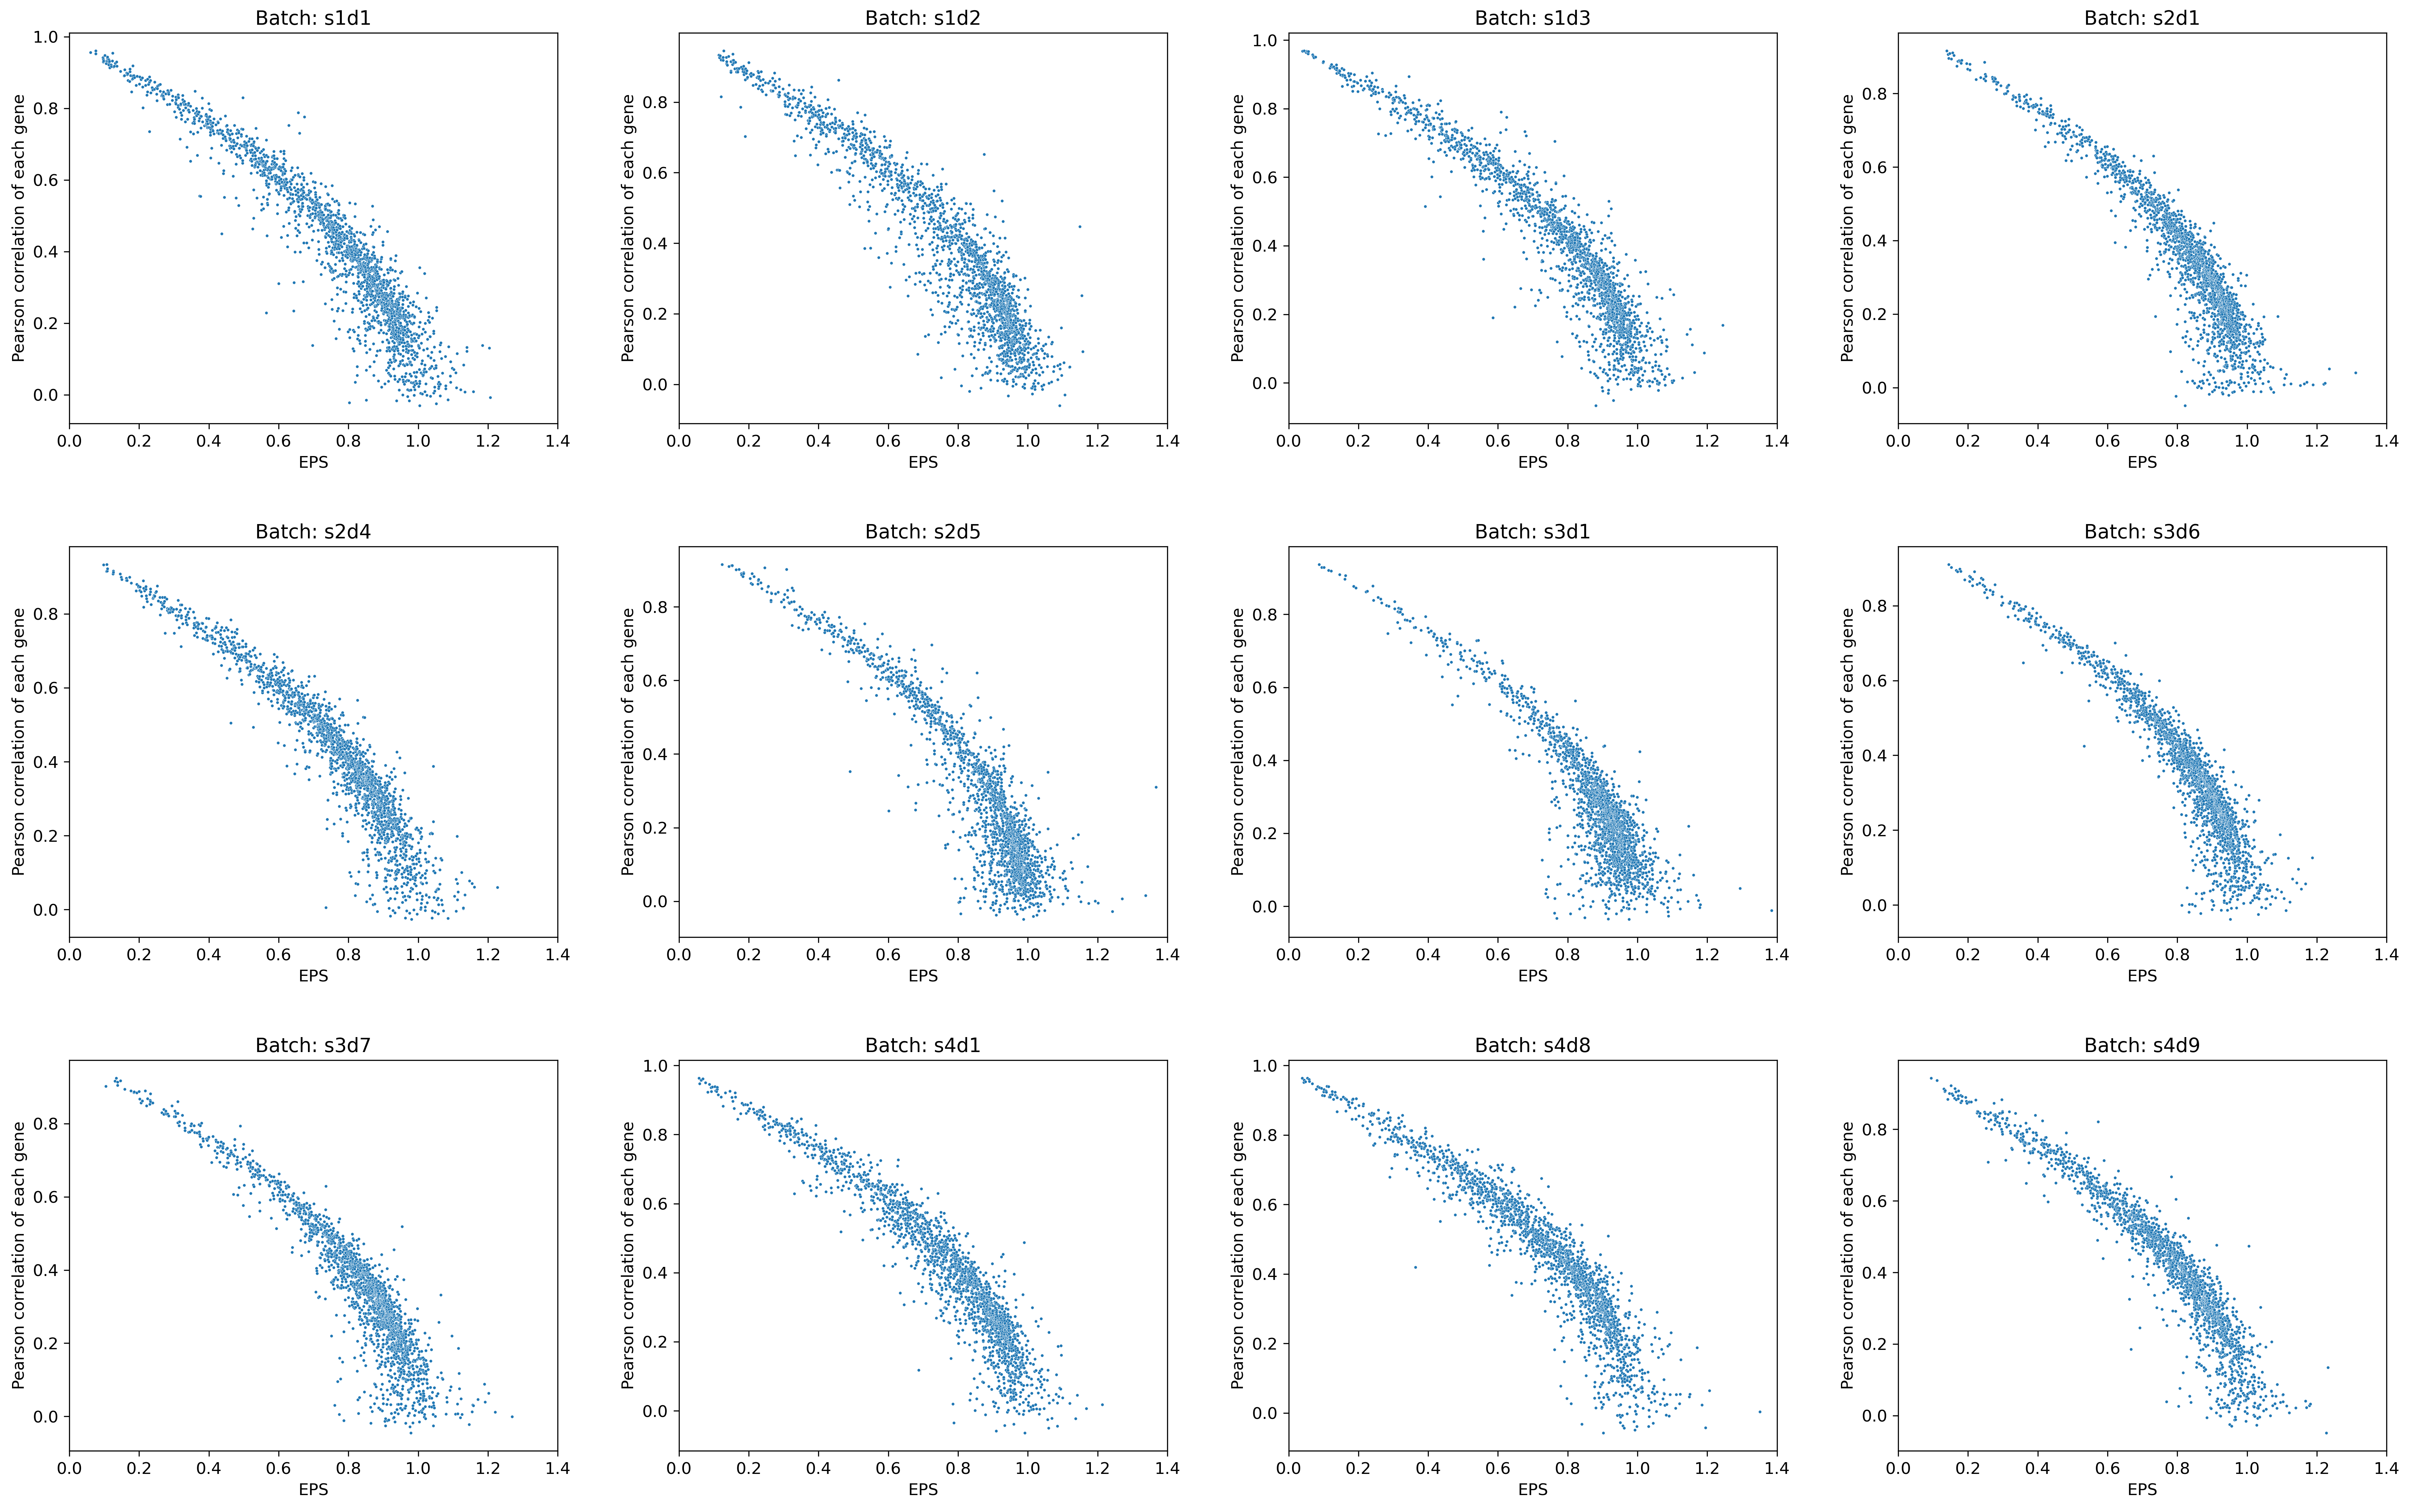

In [9]:
plot_dict = {}
for i, (batch, metrics) in enumerate(res_dict.items()):
    tmp_ax = pw.Brick(figsize=(5,4))
    ax = sns.scatterplot(x=metrics['EPS'], y=metrics['pearson_corr'], s=5, ax=tmp_ax)
    ax.set_title(f'Batch: {batch}')
    ax.set_ylabel('Pearson correlation of each gene')
    ax.set_xlim(0, 1.4)
    plot_dict[i] = tmp_ax

(plot_dict[0] | plot_dict[1] | plot_dict[2] | plot_dict[3])/ \
(plot_dict[4] | plot_dict[5] | plot_dict[6] | plot_dict[7])/ \
(plot_dict[8] | plot_dict[9] | plot_dict[10] | plot_dict[11])


Then we visualize the relationship between SPS and slice level prediction performance (Pearson correlation)

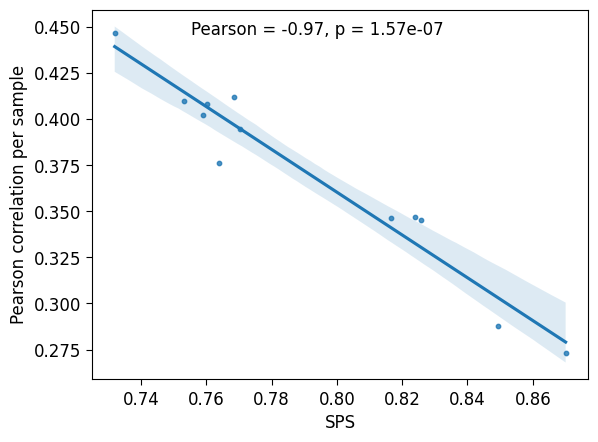

In [11]:
eps_list, pearson_list = [], []
for batch, metrics in res_dict.items():
    eps_list.append(metrics['EPS'].mean())
    pearson_list.append(metrics['pearson_corr'].mean())
tmp_df = pd.DataFrame({'EPS': eps_list, 'pearson_corr': pearson_list, 'batch': list(res_dict.keys())})
pearson, p_val = pearsonr(tmp_df["EPS"], tmp_df["pearson_corr"])
ax = sns.regplot(tmp_df, x="EPS", y="pearson_corr", scatter_kws={"s": 10})
ax.text(0.2, 0.97, f"Pearson = {pearson:.2f}, p = {p_val:.2e}", transform=ax.transAxes, fontsize=12,
        verticalalignment="top", )
ax.set_xlabel('SPS')
ax.set_ylabel('Pearson correlation per sample')
plt.show()